In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
def remove_horizontal_lines(image_path, output_path, line_thickness_threshold=5, min_line_length_ratio=0.7):
    """
    Removes horizontal black lines from an image.

    Args:
        image_path (str): Path to the input image.
        output_path (str): Path to save the image with lines removed.
        line_thickness_threshold (int): Maximum thickness of a line to be considered horizontal.
        min_line_length_ratio (float): Minimum length of a line as a ratio of image width
                                       to be considered a horizontal line.
    """
    # 1. Load the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image at {image_path}")
        return

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Invert the image if lines are black on a white background (typical for scanned documents)
    # If lines are white on a dark background, skip this or invert differently
    inverted_gray = cv2.bitwise_not(gray)

    # 2. Apply a morphological operation to detect horizontal lines
    # Define a kernel for horizontal detection. The kernel's width should be large,
    # and its height should be small to detect horizontal lines.
    kernel_len = np.array(inverted_gray.shape[1]) // 20 # Example: 1/20th of image width
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))

    # Apply morphological opening to highlight horizontal features
    # (erode then dilate to remove small noise and preserve lines)
    horizontal_lines = cv2.morphologyEx(inverted_gray, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

    # 3. Threshold the detected lines
    # This will create a binary image where detected lines are white
    _, horizontal_thresh = cv2.threshold(horizontal_lines, 40, 255, cv2.THRESH_BINARY) # Adjust threshold as needed

    # 4. Find contours of the detected lines
    contours, _ = cv2.findContours(horizontal_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask to draw the lines that need to be removed
    mask = np.zeros_like(img)
    image_width = img.shape[1]

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        # Filter contours based on size and aspect ratio to ensure they are horizontal lines
        if h <= line_thickness_threshold and w > image_width * min_line_length_ratio:
            # Draw the detected line onto the mask
            cv2.rectangle(mask, (x, y), (x + w, y + h), (255, 255, 255), -1) # Draw white rectangle

    # 5. Inpaint the original image using the mask
    # The inpainting algorithm reconstructs the removed areas from surrounding pixels.
    # INPAINT_TELEA or INPAINT_NS are the two main algorithms. TELEA is often good for small defects.
    result_img = cv2.inpaint(img, cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY), 3, cv2.INPAINT_TELEA)

    # 6. Save the result
    cv2.imwrite(output_path, result_img)
    print(f"Processed image saved to {output_path}")

    return result_img



Processed image saved to processed_cropped/processed_im_280.png
Processed image saved to processed_cropped/processed_im_281.png
Processed image saved to processed_cropped/processed_im_282.png
Processed image saved to processed_cropped/processed_im_283.png
Processed image saved to processed_cropped/processed_im_284.png
Processed image saved to processed_cropped/processed_im_285.png
Processed image saved to processed_cropped/processed_im_286.png
Processed image saved to processed_cropped/processed_im_287.png
Processed image saved to processed_cropped/processed_im_288.png
Processed image saved to processed_cropped/processed_im_289.png


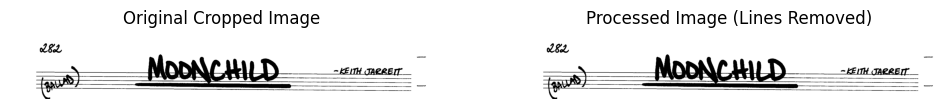

In [3]:
# --- Example Usage with your current loop structure ---
jrb_filepath = os.path.join("resources", "Jazz_Real_Book.pdf") # Replace with your actual PDF path
cropped_output_dir = "cropped"
processed_output_dir = "processed_cropped"

os.makedirs(cropped_output_dir, exist_ok=True)
os.makedirs(processed_output_dir, exist_ok=True)

# Generate a sample image for demonstration if you don't have one readily available
# In a real scenario, this would come from your PyMuPDF processing.
# For now, let's just make a placeholder.
# You can delete this block once you integrate it into your existing code.
if not os.path.exists(os.path.join(cropped_output_dir, "cropped_im_280.png")):
    # Create a dummy image with a black horizontal line for testing
    dummy_img = np.ones((500, 800, 3), dtype=np.uint8) * 255 # White background
    cv2.line(dummy_img, (100, 200), (700, 205), (0, 0, 0), 5) # Black horizontal line
    cv2.putText(dummy_img, "Text above line", (100, 180), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    cv2.putText(dummy_img, "Text below line", (100, 230), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    cv2.imwrite(os.path.join(cropped_output_dir, "cropped_im_280.png"), dummy_img)
    print("Created a dummy image for demonstration.")


# Integrate into your existing loop:
for page_number in range(280, 290): # Adjust range as needed

    cropped_filepath = os.path.join(cropped_output_dir, f"cropped_im_{page_number}.png")

    processed_filepath = os.path.join(processed_output_dir, f"processed_im_{page_number}.png")
    remove_horizontal_lines(cropped_filepath, processed_filepath)

    # Now, use the processed_filepath for OCR
    output_folder_name = os.path.join("output", str(page_number))
    os.makedirs(output_folder_name, exist_ok=True)

    # Initialize OCR outside the loop if possible to save time
    # ocr = PaddleOCR(lang="en", device="gpu", ...)

    # result = ocr.predict(processed_filepath) # Use the processed image

    # ... rest of your OCR processing ...

# To visualize an example:
# Ensure you have matplotlib installed: pip install matplotlib
original_img = cv2.imread(os.path.join(cropped_output_dir, "cropped_im_280.png"))
processed_img = cv2.imread(os.path.join(processed_output_dir, "processed_im_280.png"))

if original_img is not None and processed_img is not None:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title("Original Cropped Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
    plt.title("Processed Image (Lines Removed)")
    plt.axis('off')

    plt.show()

Processed image saved to processed_cropped_morph/processed_im_280.png
Processed image saved to processed_cropped_morph/processed_im_281.png
Processed image saved to processed_cropped_morph/processed_im_282.png
Processed image saved to processed_cropped_morph/processed_im_283.png
Processed image saved to processed_cropped_morph/processed_im_284.png
Processed image saved to processed_cropped_morph/processed_im_285.png
Processed image saved to processed_cropped_morph/processed_im_286.png
Processed image saved to processed_cropped_morph/processed_im_287.png
Processed image saved to processed_cropped_morph/processed_im_288.png
Processed image saved to processed_cropped_morph/processed_im_289.png


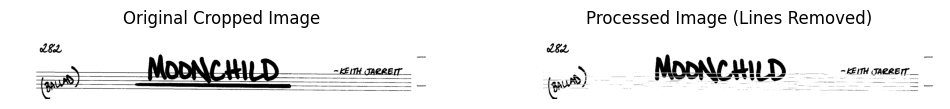

In [27]:
import cv2
import numpy as np
import os

def remove_horizontal_lines(image_path, output_path, kernel_width=50, kernel_height=1):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image at {image_path}")
        return

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Binary inverse (text=white, bg=black)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Kernel to detect horizontal lines
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_width, kernel_height))

    # Extract horizontal lines
    horizontal_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)

    # Subtract lines from the binary image
    no_lines = cv2.subtract(binary, horizontal_lines)

    # Invert back (text=black, bg=white)
    final = cv2.bitwise_not(no_lines)

    cv2.imwrite(output_path, final)
    print(f"Processed image saved to {output_path}")

# --- Example Usage (similar to the previous response) ---
# Replace with your actual file paths
jrb_filepath = "your_document.pdf"
cropped_output_dir = "cropped"
processed_output_dir = "processed_cropped_morph"

os.makedirs(processed_output_dir, exist_ok=True)

# Loop to process your images
for page_number in range(280, 290):
    # Your PyMuPDF code to crop the image goes here
    # cropped_filepath = os.path.join(cropped_output_dir, f"cropped_im_{page_number}.png")
    
    # Assuming the cropped image already exists from your prior runs
    cropped_filepath = os.path.join(cropped_output_dir, f"cropped_im_{page_number}.png")
    if not os.path.exists(cropped_filepath):
        print(f"File not found: {cropped_filepath}. Please run the cropping script first.")
        continue

    processed_filepath = os.path.join(processed_output_dir, f"processed_im_{page_number}.png")
    
    # Apply the morphological opening
    remove_horizontal_lines(cropped_filepath, processed_filepath, kernel_width=100)

    # Your PaddleOCR code would then use the processed_filepath
    # ocr.predict(processed_filepath)

original_img = cv2.imread(os.path.join(cropped_output_dir, "cropped_im_280.png"))
processed_img = cv2.imread(os.path.join(processed_output_dir, "processed_im_280.png"))

if original_img is not None and processed_img is not None:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title("Original Cropped Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
    plt.title("Processed Image (Lines Removed)")
    plt.axis('off')

    plt.show()

Found 14 contours
Contour at (x=1366, y=345, w=167, h=3, ratio=55.7)
Contour at (x=975, y=342, w=387, h=5, ratio=77.4)
Contour at (x=831, y=341, w=143, h=3, ratio=47.7)
Contour at (x=690, y=340, w=140, h=3, ratio=46.7)
Contour at (x=432, y=338, w=114, h=3, ratio=38.0)
Contour at (x=742, y=308, w=928, h=29, ratio=32.0)
Contour at (x=960, y=295, w=546, h=6, ratio=91.0)
Contour at (x=688, y=293, w=151, h=3, ratio=50.3)
Contour at (x=820, y=271, w=870, h=8, ratio=108.8)
Contour at (x=158, y=266, w=258, h=4, ratio=64.5)
Contour at (x=1843, y=254, w=122, h=3, ratio=40.7)
Contour at (x=417, y=244, w=1234, h=11, ratio=112.2)
Contour at (x=267, y=243, w=141, h=3, ratio=47.0)
Contour at (x=158, y=242, w=108, h=3, ratio=36.0)
Saved cleaned image to processed_cropped_morph/processed_im_280.png
Found 5 contours
Contour at (x=1567, y=265, w=415, h=3, ratio=138.3)
Contour at (x=333, y=242, w=1856, h=13, ratio=142.8)
Contour at (x=1385, y=225, w=213, h=3, ratio=71.0)
Contour at (x=2106, y=205, w=275, 

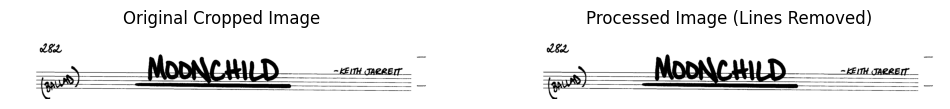

In [24]:
def remove_horizontal_lines_contours(image_path, output_path, kernel_width=100, kernel_height=2):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Step 1: Binary inverse (text white, bg black)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    cv2.imwrite("debug_binary.png", binary)

    # Step 2: Morph open to isolate horizontal lines
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_width, kernel_height))
    detected_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    cv2.imwrite("debug_detected_lines.png", detected_lines)

    # Step 3: Find contours of detected line regions
    contours, _ = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    print(f"Found {len(contours)} contours")
    mask = np.zeros_like(gray)

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        ratio = w / max(h, 1)
        print(f"Contour at (x={x}, y={y}, w={w}, h={h}, ratio={ratio:.1f})")
        if w > 30 and h <= 3 and ratio > 10:   # wide + thin
            cv2.drawContours(mask, [cnt], -1, 255, thickness=-1)

    cv2.imwrite("debug_mask.png", mask)

    # Step 4: Inpaint on original image using mask
    no_lines = cv2.inpaint(img, mask, inpaintRadius=2, flags=cv2.INPAINT_TELEA)

    cv2.imwrite(output_path, no_lines)
    print(f"Saved cleaned image to {output_path}")


cropped_output_dir = "cropped"
processed_output_dir = "processed_cropped_morph"

os.makedirs(processed_output_dir, exist_ok=True)

# Loop to process your images
for page_number in range(280, 290):
    # Your PyMuPDF code to crop the image goes here
    # cropped_filepath = os.path.join(cropped_output_dir, f"cropped_im_{page_number}.png")
    
    # Assuming the cropped image already exists from your prior runs
    cropped_filepath = os.path.join(cropped_output_dir, f"cropped_im_{page_number}.png")
    if not os.path.exists(cropped_filepath):
        print(f"File not found: {cropped_filepath}. Please run the cropping script first.")
        continue

    processed_filepath = os.path.join(processed_output_dir, f"processed_im_{page_number}.png")
    
    # Apply the morphological opening
    remove_horizontal_lines_contours(cropped_filepath, processed_filepath, kernel_width=50)

    # Your PaddleOCR code would then use the processed_filepath
    # ocr.predict(processed_filepath)

original_img = cv2.imread(os.path.join(cropped_output_dir, "cropped_im_280.png"))
processed_img = cv2.imread(os.path.join(processed_output_dir, "processed_im_280.png"))

if original_img is not None and processed_img is not None:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title("Original Cropped Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
    plt.title("Processed Image (Lines Removed)")
    plt.axis('off')

    plt.show()
